# Lib import

In [53]:
import os
import sys
import json
import numpy as np
import pandas as pd
# from datasets import load_metric
from pathlib import Path
from rouge_score import rouge_scorer
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

# Load dataset

In [2]:
RAWDATAFILES = {
    "train": "training_complete.jsonl",
    "val": "validation_complete.jsonl",
    "test": "testing_with_paper_release.jsonl"
}

def load_data(split):
    main_path = str((Path().absolute()).parents[0])    
    filepath = f"{main_path}/dataset_MuP/{RAWDATAFILES[split]}"
    try:
        with open(filepath, 'r') as json_file:
            json_list = list(json_file)
        col_name = ["paper_id","summary"]
    except:
        print(f"Warning: Did not load dataset from {filepath}")
        return
    # summary_df = pd.DataFrame(columns=col_name)
    summary_list = []
    for json_str in json_list[:]:
        result = json.loads(json_str)
        # df = pd.DataFrame([[result["paper_id"], result["summary"]]], columns=col_name)
        summary_list.append({
            "paper_id": result["paper_id"],
            "summary": result["summary"],
        })
        # summary_df = pd.concat([summary_df,df])
    return pd.DataFrame(summary_list)

def split_sum_num(df):
    num_paper = df.groupby(['paper_id']).count()
    num_paper['num_paper'] = 1
    num_paper.groupby(['summary']).count()
    num_paper = df.groupby(['paper_id']).count()
    num_paper['num_paper'] = 1
    num_paper.groupby(['summary']).count()
    num_paper.drop('num_paper', inplace=True,axis=1)
    num_paper.sort_values(["summary"])

    df_list = []
    for i in range(0, max(num_paper['summary'])):
        paper_id = (list((num_paper[num_paper["summary"]==(i+1)]).index))
        df_i = df[df.paper_id.isin(paper_id)].sort_values("paper_id")
        df_list.append(df_i.groupby('paper_id').apply(lambda df_: df_[['summary']].values.flatten()).apply(pd.Series).reset_index())
        
    return df_list

In [3]:
summary_df = load_data("train")
summary_df.head()

,paper_id,summary
0,SP:4d08cdb2de2044bcb574a425b42963b83fbebfbc,This paper investigates kernel ridge-less regr...
1,SP:b80bc890180934092cde037b49d94d6e4e06fad9,This paper presents a novel way of making full...
2,SP:09f2fe6a482bbd6f9bd2c62aa841f995171ba939,This paper proposes a new framework that compu...
3,SP:a1e2218e6943bf138aeb359e23628676b396ed66,This work proposes a deep reinforcement learni...
4,SP:43e525fb3fa611df7fd44bd3bc9843e57b154c66,This paper proposes 3 deep generative models b...


In [4]:
df_list = split_sum_num(summary_df)

In [5]:
print(len(df_list))
df_list[6]

7


,paper_id,0,1,2,3,4,5,6
0,SP:2cf4a3964537ff5dd1f7b600ab567b4d0b3cc03e,This work reports the problem of image classif...,The paper evaluates pathologies of modern neur...,The paper identifies sparse sets of pixels whi...,The paper presents an interesting finding that...,"Authors define ""overinterpretation"" as an unde...","This paper proposes ""overinterpretation"" which...",The work utilizes the SIS (a local feature-imp...
1,SP:b622788bec805621c2abf11ffa25c0d55e50f4d3,The paper performs a detailed hyperparameter s...,This paper was previously rejected by NeurIPS ...,"In data-parallel distributed training, increas...",This paper revisits the effectiveness of the o...,I carefully read the responses from the author...,"In this work, the authors compared the standar...",The authors detail the significant effort requ...
2,SP:ddc796b9185d372f4d0829f436bbca50c3990867,This paper introduces a Jax package for implic...,The paper proposes a modular and efficient fra...,This paper presents a module for implicit diff...,The paper promises extension of Google’s JAX l...,This paper provides a unified tool for combini...,"A good paper considers a critical problem, but...",The authors propose a unified modular framewor...
3,SP:f202f3d6780876a0bdd7d7bd4d7047719a145177,The authors propose a novel skill discovery me...,This method learns a space of intrinsic goals ...,The paper presents a framework for an unsuperv...,The paper proposes an unsupervised exploration...,To increase the state space coverage with unsu...,The paper proposes a novel algorithm for learn...,The idea of this work is to maximize coverage ...


# Score calculation

In [6]:
def n_scores(df, subscore_col):
    n = len(df.columns)-1
    pairs = [f'{i}-{j}' for i in range(n) for j in range(i+1, n)]
    col = pd.MultiIndex.from_product([subscore_col, pairs])
    scores = pd.DataFrame(columns=col)
    scores.insert(0, "paper_id", df["paper_id"])
    # scores.set_index("paper_id", inplace=True)
    return scores

## ROUGE Score

In [7]:
# rougescore = load_metric("rouge")

# def rouge_cal(df):
#     n = len(df.columns)-1
#     print(f"Calculating ROUGE on {n} summaries")

#     rouge_list = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
#     score_list = ['precision', 'recall', 'fmeasure']

#     df_score_dict = {}
#     mux = pd.MultiIndex.from_product([["summary"],(list(df.columns))[1:]])
#     df_score = pd.DataFrame(columns=mux)
#     df_score.insert(0, "paper_id", df["paper_id"])
#     for col in df:
#         if col != 'paper_id':
#             df_score[('summary', col)] = df[col]
#     df_score = df_score.merge(n_scores(df, score_list), left_on='paper_id', right_on='paper_id')
#     for r in rouge_list:
#         df_score_dict[r] = df_score.copy(deep=True)

#     df_len = len(df)
#     for idx, row in df.iterrows():
#         sys.stdout.write(f"\r{idx+1}/{df_len}")
#         sys.stdout.flush()
#         for i in range(n):
#             for j in range(i+1,n):
#                 pair = f'{i}-{j}'
#                 # score = rougescore.compute(predictions=[row[i]], references=[row[j]], use_stemmer=False)
#                 score = get_rouge(refs=[row[j]], hyps=[row[i]])
#                 print(score)
#                 for r in rouge_list:
#                     df_score_dict[r].loc[idx, ('precision', pair)] = score[""]
#                     df_score_dict[r].loc[idx, ('recall', pair)] = score[""]
#                     df_score_dict[r].loc[idx, ('fmeasure', pair)] = score[""]

#     return df_score_dict

In [8]:
def get_rouge(refs, hyps):
    if not isinstance(refs, list): refs=[refs]
    if not isinstance(hyps, list): hyps=[hyps]

    metrics = ['rouge1', 'rouge2', 'rougeL']
    scorer = rouge_scorer.RougeScorer(metrics, use_stemmer=True)
    
    if len(refs)!=len(hyps):
        raise Exception(f"No. of Refs and Hyps are not equal")
    results = {}
    for metric in metrics: results[metric]=[] 
    for idx in range(len(refs)):
        scores = scorer.score(refs[idx].strip(), hyps[idx].strip())
        for metric in metrics: results[metric].append(scores[metric].fmeasure)
    # print(results)
    # results = {rouge_metric: np.average(rouge_metric_scores) for (rouge_metric, rouge_metric_scores) in results.items()}
    return results['rouge1'], results['rouge2'], results['rougeL']

# def rouge_cal_simple(df):

In [20]:
dict_rouge = {}
for n, df in enumerate(df_list):
    if n+1 > 1:
        dict_rouge[n+1] = {
            'rouge1': df.copy(),
            'rouge2': df.copy(),
            'rougeL': df.copy(),
        }
        print(f"Calculating {n+1} summaries papers")
        for i in range(n+1):
            for j in range(i+1,n+1):
                pair = f'{i}-{j}'
                # print(f"\tcalculating between {i} and {j}")
                results = get_rouge(list(df[i]), list(df[j]))
                for k, result in enumerate(results):
                    dict_rouge[n+1][list(dict_rouge[n+1].keys())[k]][pair] = result
        # break

Calculating 2 summaries papers
Calculating 3 summaries papers
Calculating 4 summaries papers
Calculating 5 summaries papers
Calculating 6 summaries papers
Calculating 7 summaries papers


In [27]:
for k1 in dict_rouge.keys():
    pair = [f'{i}-{j}' for i in range(k1) for j in range(i+1,k1)]
    for k2 in dict_rouge[k1].keys():
        dict_rouge[k1][k2]['max'] = dict_rouge[k1][k2][pair].max(axis=1)
        dict_rouge[k1][k2]['mean'] = dict_rouge[k1][k2][pair].mean(axis=1)
        dict_rouge[k1][k2]['min'] = dict_rouge[k1][k2][pair].min(axis=1)

In [67]:
dict_rouge[2]['rouge1']

,paper_id,0,1,0-1,max,mean,min
0,SP:0007ee9ce7dfaf12a7dff4aa2979403aed9397d7,This paper proposed a novel benchmark for rela...,The paper focuses on the relation extraction t...,0.354286,0.354286,0.354286,0.354286
1,SP:001a31f7a439ab22943dedb4fa4d46e3dd56e603,This paper is an interesting exploratory study...,This paper explores learning chess from raw no...,0.455959,0.455959,0.455959,0.455959
2,SP:001e57e71bafdb52d6511bdd6aa73b78d60248f2,The manuscript considers the problem of imitat...,"The paper proposes an imitation method, I2L, t...",0.380645,0.380645,0.380645,0.380645
3,SP:004f41dfc870c5a9b347d118d7e41d7c3db77b91,This paper uses pruning and model distillation...,This paper proposes a new framework which comb...,0.339869,0.339869,0.339869,0.339869
4,SP:00578dd55a640c10dbf22f647b736e49f6ee3c32,"The authors introduce CP-Flows, a way to param...",This paper proposes the flow based representat...,0.320000,0.320000,0.320000,0.320000
...,...,...,...,...,...,...,...
2840,SP:ff7cdd0d7c011a59c7fc3088f7dbd6145fc3ca72,This paper provides theoretical analysis of gr...,The paper focuses on the link prediction task ...,0.251163,0.251163,0.251163,0.251163
2841,SP:ff9b59f83d1d206ef246db96f13b43ac39c54db8,In this paper the authors study stochastic pro...,This paper studies the stochastic proximal poi...,0.449704,0.449704,0.449704,0.449704
2842,SP:ffa69b99230ed18f02cbb7acb37cf3cd801ec908,The paper proposes a new GNN architecture base...,"In this paper, the authors proposed a generali...",0.333333,0.333333,0.333333,0.333333
2843,SP:ffacc996034978d7851cf8fa7a0ea41f868c9354,This paper extends the work of Hindsight Exper...,Following recent work on Hindsight Experience ...,0.342857,0.342857,0.342857,0.342857


In [68]:
df_rouge = {
    'rouge1': pd.DataFrame(),
    'rouge2': pd.DataFrame(),
    'rougeL': pd.DataFrame(),
}
for k1 in dict_rouge.keys():
    for k2 in dict_rouge[k1].keys():
        df = pd.DataFrame(list(dict_rouge[k1][k2]['min']), columns=["score"])
        df["Num_summaries"] = k1
        df["paper_id"] = dict_rouge[k1][k2]['paper_id']
        df_rouge[k2] = pd.concat([df_rouge[k2], df])
    # break
df_rouge['rouge1'].head()

,score,Num_summaries,paper_id
0,0.354286,2,SP:0007ee9ce7dfaf12a7dff4aa2979403aed9397d7
1,0.455959,2,SP:001a31f7a439ab22943dedb4fa4d46e3dd56e603
2,0.380645,2,SP:001e57e71bafdb52d6511bdd6aa73b78d60248f2
3,0.339869,2,SP:004f41dfc870c5a9b347d118d7e41d7c3db77b91
4,0.320000,2,SP:00578dd55a640c10dbf22f647b736e49f6ee3c32


In [86]:
row_min = df_rouge['rouge1'][df_rouge['rouge1']['score']==df_rouge['rouge1']['score'].min()]
paper_id = row_min['paper_id'].iloc[0]
n = row_min['Num_summaries'].iloc[0]
data_min = dict_rouge[n]['rouge1'][dict_rouge[n]['rouge1']['paper_id']==paper_id]
for i in range(n):
    print(f"Summary: {i}")
    print(data_min[i].iloc[0])
data_min

Summary: 0
This paper proposes a loss for domain generalization. The loss is learned by meta-learning on based on RotatedMNIST. The paper evaluate the loss's generalization ability in several other datasets.
Summary: 1
This paper proposed a novel viewpoint in domain generalization, i.e, the loss function search. Specifically, the search procedure is decomposed as a bi-level optimization and solved through implicit function. The author later adopted the Neumann series for memory saving. The extensive empirical results validate the correctness of the proposed approach.  ====== Final Update after rolling discussions  I would appreciate the authors for the detailed responses and I have read the rebuttal. Unfortunately, the concern of rigor is still not addressed after discussion and I will maintain the same rating. Below are my *final* remarks (I fully understand your high-level idea), I hope the author will carefully rethink the paper and improve it in the future version.  - In the rebutt

,paper_id,0,1,2,0-1,0-2,1-2,max,mean,min
1930,SP:eadfda08b9d61460c60adf97ec97c7d6163ff205,This paper proposes a loss for domain generali...,This paper proposed a novel viewpoint in domai...,Authors introduce a bi-level optimization proc...,0.080586,0.246377,0.209003,0.246377,0.178655,0.080586


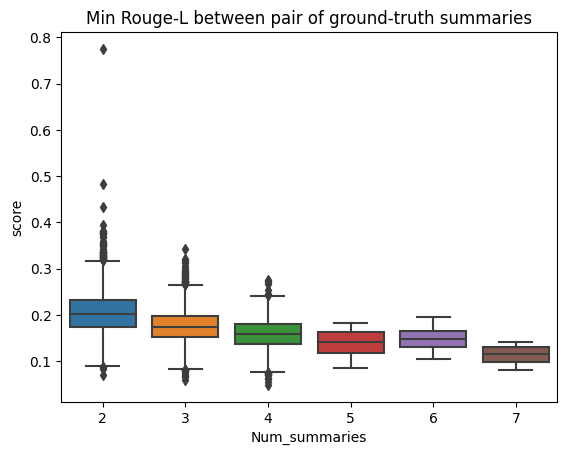

In [91]:
metrics = ['rouge1', 'rouge2', 'rougeL']
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(data=df_rouge['rougeL'], x="Num_summaries", y="score")
plt.title("Min Rouge-L between pair of ground-truth summaries")
plt.show()

In [ ]:
for n, df in enumerate(df_list):
    if n+1 > 1:
        dict_result = rouge_cal(df)
        for key, val in dict_result.items():
            # val.to_csv(f"visualization_data/rouge-between-sum/{key}/{dts}_{key}_{n+1}sum.csv")
            pass
dict_result['rouge1']

## BERT Score

In [56]:
# from evaluate import load

# bertscore = load("bertscore")
# def bertscore_cal(df):
#     n = len(df.columns)-1
#     print(f"Calculating BERTScore on {n} summaries")
    
#     score_list = ['precision', 'recall', 'f1']

#     mux = pd.MultiIndex.from_product([["summary"],(list(df.columns))[1:]])
#     df_score = pd.DataFrame(columns=mux)
#     df_score.insert(0, "paper_id", df["paper_id"])
#     for col in df:
#         if col != 'paper_id':
#             df_score[('summary', col)] = df[col]
#     df_score = df_score.merge(n_scores(df, score_list), left_on='paper_id', right_on='paper_id')

#     for i in range(n):
#         for j in range(i+1,n-1):
#             pair = f'{i}-{j}'
#             summary1 = list(df_score.loc[:, ('summary', i)])
#             summary2 = list(df_score.loc[:, ('summary', j)])
#             print(pair)
#             result = bertscore.compute(predictions=summary1, references=summary2, lang="en", rescale_with_baseline=True)
#             for score in score_list:
#                 df_score.loc[:, (score, pair)] = result[score]

#     return df_score
    
# bertscore_cal(df_list[2][:3])

In [57]:
# for n, df in enumerate(df_list):
#     if n+1 > 1:
#         result = bertscore_cal(df)
#         val.to_csv(f"visualization_data/bertscore-between-sum/{dts}_bertscore_{n+1}sum.csv")

# Count tokens

In [101]:
from transformers import BartTokenizer
TOKENIZER = BartTokenizer.from_pretrained("facebook/bart-large")
def get_token(sentence, get_len=True):
    tokens = TOKENIZER.encode(
        sentence, 
        padding=False, 
        truncation=True, 
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    if get_len: return tokens.shape[1]
    else: return tokens

In [112]:
token_dict = {}
for n, df in enumerate(df_list):
    token_dict[n+1] = pd.DataFrame()
    for i in range(n+1):
        token_dict[n+1]['paper_id'] = df['paper_id']
        token_dict[n+1][i] = df[i].apply(get_token)

In [118]:
def diff(a, b): return abs(a-b)

In [119]:
for k, v in token_dict.items():
    for i in range(k):
        for j in range(i+1, k):
            pair = f'{i}-{j}'
            v[pair] = v.apply(lambda x: diff(x[i], x[j]), axis=1)
            # print(k, pair)
token_dict[2]

,paper_id,0,1,0-1
0,SP:0007ee9ce7dfaf12a7dff4aa2979403aed9397d7,117,102,15
1,SP:001a31f7a439ab22943dedb4fa4d46e3dd56e603,96,131,35
2,SP:001e57e71bafdb52d6511bdd6aa73b78d60248f2,262,147,115
3,SP:004f41dfc870c5a9b347d118d7e41d7c3db77b91,103,100,3
4,SP:00578dd55a640c10dbf22f647b736e49f6ee3c32,157,108,49
...,...,...,...,...
2840,SP:ff7cdd0d7c011a59c7fc3088f7dbd6145fc3ca72,196,76,120
2841,SP:ff9b59f83d1d206ef246db96f13b43ac39c54db8,115,103,12
2842,SP:ffa69b99230ed18f02cbb7acb37cf3cd801ec908,218,163,55
2843,SP:ffacc996034978d7851cf8fa7a0ea41f868c9354,239,116,123


In [121]:
for k, v in token_dict.items():
    pair = [f'{i}-{j}' for i in range(k) for j in range(i+1,k)]
    v['max'] = v[pair].max(axis=1)

In [123]:
token_dict[3]

,paper_id,0,1,2,0-1,0-2,1-2,max
0,SP:001ae7379191bb40fc356a37deb2f0ffc4426e52,79,175,47,96,32,128,128
1,SP:0045d9a733e9d3db6e42c4fcadaa7dc57f7b5004,174,62,95,112,79,33,112
2,SP:0055dca69c153ed21b420741c479a2ef00be2ef6,148,137,93,11,55,44,55
3,SP:006a3aabe6e2d03798d9b441665ef1d1d30a7e1e,214,108,136,106,78,28,106
4,SP:007cfdff69f09c5edd1df48ad280a2d05cc9862a,168,106,74,62,94,32,94
...,...,...,...,...,...,...,...,...
2111,SP:ffbadf3bae4e41b07ea7efac41512af9ac924951,61,70,114,9,53,44,53
2112,SP:ffca45ed1b7e838e71cce6cb1b264d44c847ab87,123,226,83,103,40,143,143
2113,SP:ffd312ea33f60fdb1e49a84bd478f368deec85bf,100,94,510,6,410,416,416
2114,SP:ffe7e45f9625c96a460debf867ffe458904c721c,151,280,143,129,8,137,137


In [138]:
max_diff = pd.DataFrame()
for k, v in token_dict.items():
    if (v['max'].isna()).any(): continue
    df = pd.DataFrame()
    df["token_diff"] = v['max']
    df['Num_summaries'] = k
    max_diff = pd.concat([max_diff, df])
max_diff


,token_diff,Num_summaries
0,15,2
1,35,2
2,115,2
3,3,2
4,49,2
...,...,...
14,81,6
0,81,7
1,307,7
2,199,7


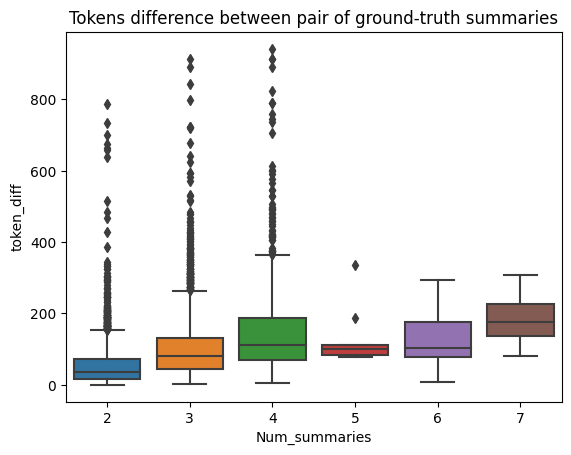

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(data=max_diff, x="Num_summaries", y="token_diff")
plt.title("Tokens difference between pair of ground-truth summaries")
plt.show()

In [142]:
summary_df['tokens'] = summary_df['summary'].apply(get_token)
summary_df

,paper_id,summary,tokens
0,SP:4d08cdb2de2044bcb574a425b42963b83fbebfbc,This paper investigates kernel ridge-less regr...,76
1,SP:b80bc890180934092cde037b49d94d6e4e06fad9,This paper presents a novel way of making full...,91
2,SP:09f2fe6a482bbd6f9bd2c62aa841f995171ba939,This paper proposes a new framework that compu...,100
3,SP:a1e2218e6943bf138aeb359e23628676b396ed66,This work proposes a deep reinforcement learni...,83
4,SP:43e525fb3fa611df7fd44bd3bc9843e57b154c66,This paper proposes 3 deep generative models b...,106
...,...,...,...
18929,SP:0d872fb4321f3a4a3fc61cf4d33b0c7e33f2d695,This paper presents a RNN-RL based method for ...,184
18930,SP:4706017e6f8b958c7d0825fed98b285ea2994b59,This paper proposes a new pointwise convolutio...,95
18931,SP:4706017e6f8b958c7d0825fed98b285ea2994b59,This paper presents a new pointwise convolutio...,137
18932,SP:63ad3be1dae7ede5c02a847304072c1cbc91b1cb,This paper proposes to model various uncertain...,208


/tmp/ipykernel_22885/3973129314.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(summary_df['tokens'], hist=True)


Text(0.5, 1.0, 'Token length distribution of groud truth summaries')

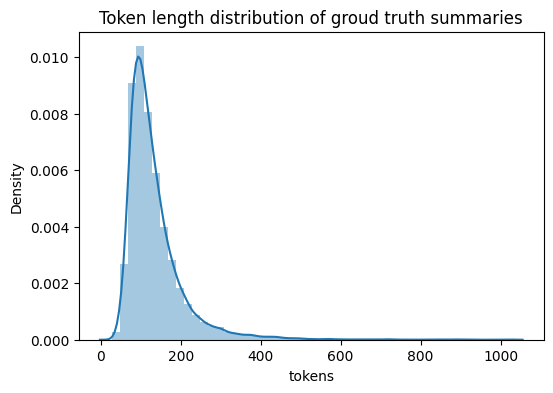

In [145]:
plt.rcParams['figure.figsize'] = [6, 4]

sns.distplot(summary_df['tokens'], hist=True)
# plt.xlabel()
plt.title("Token length distribution of groud truth summaries")


In [ ]:
sns.boxplot(data=max_diff, x="Num_summaries", y="token_diff")
plt.title("Tokens difference between pair of ground-truth summaries")
plt.show()